In [ ]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCTX1H/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCTX1H/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBCTX1H/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [ ]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [ ]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [ ]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary 
text_encoder.adapt(X_train)

In [ ]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
### Example of how a text vectorization layer works. It maps strings to integers.

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

1/1 [==============================] - 0s 151ms/step


array([[ 10, 179,   6,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  79,  22, 179,   6,   1,  19,  10, 179,   6,   1]])

In [ ]:
# Note: the vectorization process is not completely reversible due to the limited vocabulary size
print("Original: ", X_train[0])
print()
print("Round-trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK]

#GRU Section

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model_gru = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.GRU(units=64), # Output dimension of LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model_gru.summary()
print([layer.supports_masking for layer in model_gru.layers])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,185
Trainable params: 93,185
Non-trainable params: 0
__________________________________________________

In [ ]:
# Compile the model
model_gru.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size = 2048, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
10/10 [==============================] - 15s 534ms/step - loss: 0.6923 - accuracy: 0.5369 - val_loss: 0.6906 - val_accuracy: 0.5736
Epoch 2/10
10/10 [==============================] - 3s 310ms/step - loss: 0.6859 - accuracy: 0.6016 - val_loss: 0.6794 - val_accuracy: 0.6074
Epoch 3/10
10/10 [==============================] - 3s 308ms/step - loss: 0.6613 - accuracy: 0.6385 - val_loss: 0.6389 - val_accuracy: 0.6448
Epoch 4/10
10/10 [==============================] - 3s 307ms/step - loss: 0.5772 - accuracy: 0.7053 - val_loss: 0.4866 - val_accuracy: 0.7792
Epoch 5/10
10/10 [==============================] - 3s 324ms/step - loss: 0.4622 - accuracy: 0.7873 - val_loss: 0.5050 - val_accuracy: 0.7844
Epoch 6/10
10/10 [==============================] - 3s 296ms/step - loss: 0.4538 - accuracy: 0.7937 - val_loss: 0.4380 - val_accuracy: 0.7988
Epoch 7/10
10/10 [==============================] - 3s 285ms/step - loss: 0.3850 - accuracy: 0.8338 - val_loss: 0.3810 - val_accuracy: 0.8326
Epoch

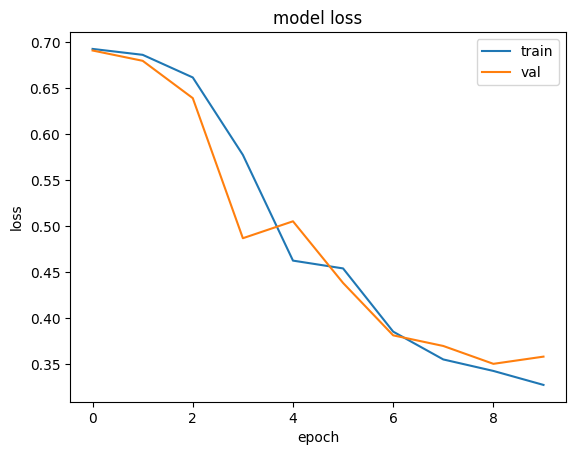

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

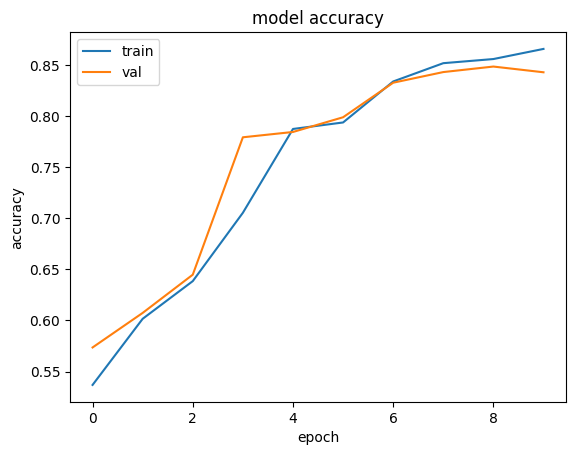

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_gru.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 10s 13ms/step - loss: 0.3525 - accuracy: 0.8493
Test Loss: 0.35247647762298584
Test Accuracy: 0.8492799997329712


# Bi-LSTM Section

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model_bi = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model_bi.summary()

print([layer.supports_masking for layer in model_bi.layers])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [ ]:
# Compile the model
model_bi.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history_bi = model_bi.fit(X_train, y_train, epochs=10, batch_size = 64, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
313/313 [==============================] - 55s 143ms/step - loss: 0.4984 - accuracy: 0.7414 - val_loss: 0.4135 - val_accuracy: 0.8054
Epoch 2/10
313/313 [==============================] - 29s 93ms/step - loss: 0.3514 - accuracy: 0.8501 - val_loss: 0.4031 - val_accuracy: 0.8306
Epoch 3/10
313/313 [==============================] - 23s 75ms/step - loss: 0.3341 - accuracy: 0.8587 - val_loss: 0.3372 - val_accuracy: 0.8524
Epoch 4/10
313/313 [==============================] - 23s 74ms/step - loss: 0.3146 - accuracy: 0.8666 - val_loss: 0.3381 - val_accuracy: 0.8544
Epoch 5/10
313/313 [==============================] - 23s 74ms/step - loss: 0.3024 - accuracy: 0.8730 - val_loss: 0.3382 - val_accuracy: 0.8552
Epoch 6/10
313/313 [==============================] - 23s 75ms/step - loss: 0.2795 - accuracy: 0.8819 - val_loss: 0.3600 - val_accuracy: 0.8426
Epoch 7/10
313/313 [==============================] - 23s 73ms/step - loss: 0.2639 - accuracy: 0.8898 - val_loss: 0.4027 - val_accuracy

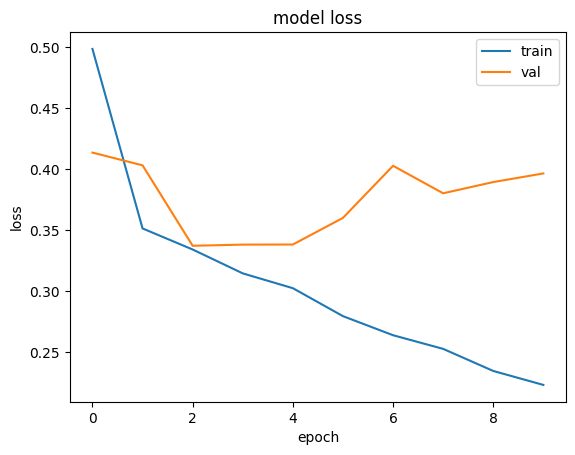

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

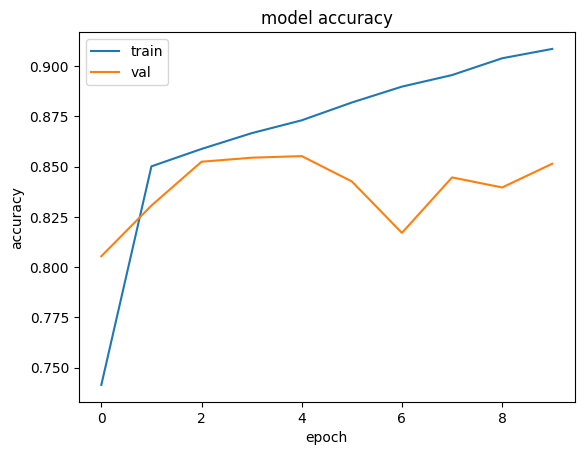

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_bi.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 19s 24ms/step - loss: 0.3822 - accuracy: 0.8526
Test Loss: 0.3821929395198822
Test Accuracy: 0.8526399731636047


# Conv1D Section

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model_conv = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64,
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer   
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model_conv.summary()
print([layer.supports_masking for layer in model_conv.layers])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          64000     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         24704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                      

In [ ]:
# Compile the model
model_conv.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history_conv = model_conv.fit(X_train, y_train, epochs=10, batch_size = 64, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
313/313 [==============================] - 45s 118ms/step - loss: 0.4237 - accuracy: 0.7979 - val_loss: 0.5392 - val_accuracy: 0.8440
Epoch 2/10
313/313 [==============================] - 12s 37ms/step - loss: 0.2634 - accuracy: 0.8912 - val_loss: 0.3359 - val_accuracy: 0.8556
Epoch 3/10
313/313 [==============================] - 9s 29ms/step - loss: 0.1833 - accuracy: 0.9278 - val_loss: 0.3500 - val_accuracy: 0.8630
Epoch 4/10
313/313 [==============================] - 8s 27ms/step - loss: 0.1070 - accuracy: 0.9622 - val_loss: 0.4091 - val_accuracy: 0.8542
Epoch 5/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0638 - accuracy: 0.9783 - val_loss: 0.4833 - val_accuracy: 0.8572
Epoch 6/10
313/313 [==============================] - 7s 23ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.5775 - val_accuracy: 0.8430
Epoch 7/10
313/313 [==============================] - 7s 23ms/step - loss: 0.0456 - accuracy: 0.9845 - val_loss: 0.6113 - val_accuracy: 0.8

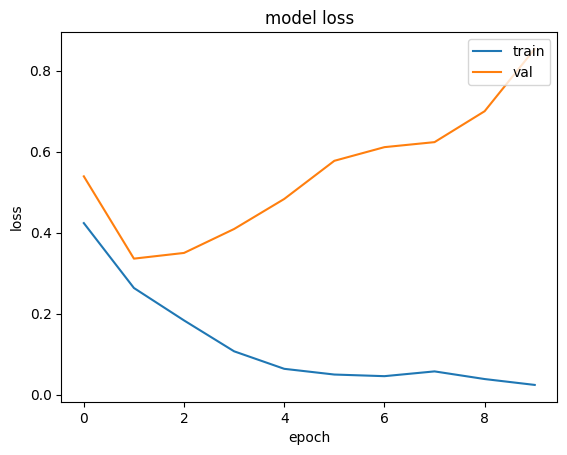

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

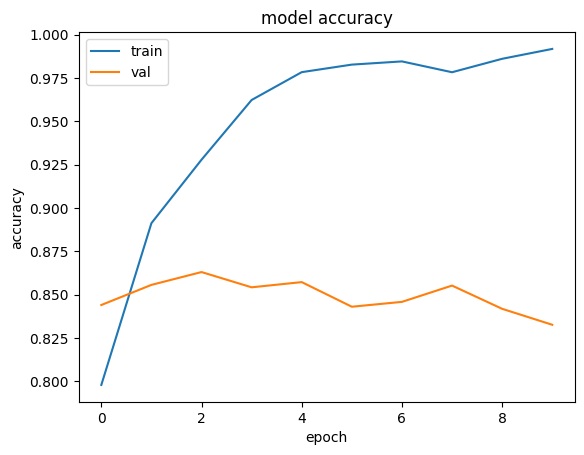

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_conv.history['accuracy'])
plt.plot(history_conv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_conv.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 14s 18ms/step - loss: 0.8347 - accuracy: 0.8346
Test Loss: 0.8346829414367676
Test Accuracy: 0.834559977054596


# GloVe Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts([x.decode('utf-8') for x in X_train])

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.array(records[1:], dtype='float64')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

**Glove model with unchanged data set compared to other implementations and use text_vectorization layer:**

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model_glove = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(tokenizer.word_index) + 1, # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=50,
        mask_zero=True, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
        weights=[embedding_matrix]),
             # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.LSTM(units=64), # Output dimension of LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model_glove.summary()
print([layer.supports_masking for layer in model_glove.layers])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 50)          4007650   
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,041,315
Trainable params: 4,041,315
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_glove.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history_glove = model_glove.fit(X_train, y_train, epochs=10, batch_size = 128, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
157/157 [==============================] - 24s 121ms/step - loss: 0.6606 - accuracy: 0.5923 - val_loss: 0.5716 - val_accuracy: 0.7034
Epoch 2/10
157/157 [==============================] - 9s 57ms/step - loss: 0.5003 - accuracy: 0.7631 - val_loss: 0.4457 - val_accuracy: 0.7956
Epoch 3/10
157/157 [==============================] - 10s 64ms/step - loss: 0.4062 - accuracy: 0.8255 - val_loss: 0.3669 - val_accuracy: 0.8378
Epoch 4/10
157/157 [==============================] - 10s 62ms/step - loss: 0.3697 - accuracy: 0.8404 - val_loss: 0.3567 - val_accuracy: 0.8476
Epoch 5/10
157/157 [==============================] - 8s 48ms/step - loss: 0.3565 - accuracy: 0.8493 - val_loss: 0.4327 - val_accuracy: 0.7992
Epoch 6/10
157/157 [==============================] - 10s 61ms/step - loss: 0.3328 - accuracy: 0.8615 - val_loss: 0.3399 - val_accuracy: 0.8600
Epoch 7/10
157/157 [==============================] - 10s 65ms/step - loss: 0.3310 - accuracy: 0.8608 - val_loss: 0.3413 - val_accuracy: 

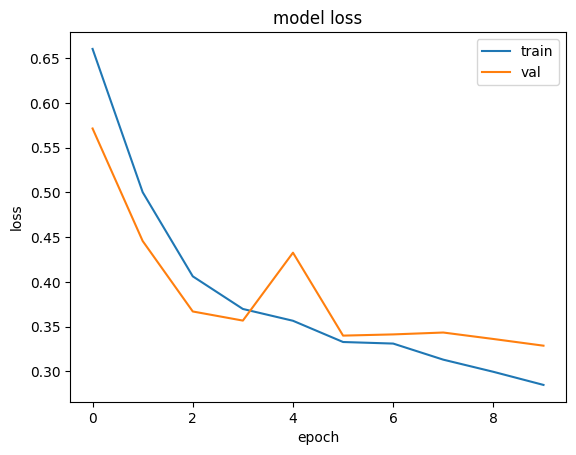

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

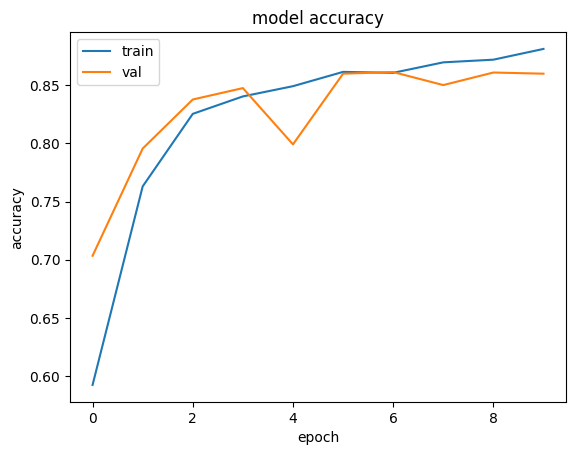

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_glove.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 17s 22ms/step - loss: 0.3238 - accuracy: 0.8612
Test Loss: 0.3238295018672943
Test Accuracy: 0.8611599802970886


**Glove model with modified dataset using tokenizer.texts_to_sequences and pad_sequences and then removing the text_vectorization layer:**

In [ ]:
X_train_glove = tokenizer.texts_to_sequences([x.decode('utf-8') for x in X_train])
X_val_glove = tokenizer.texts_to_sequences([x.decode('utf-8') for x in X_val])
X_test_glove = tokenizer.texts_to_sequences([x.decode('utf-8') for x in X_test])

X_train_glove = pad_sequences(X_train_glove, padding = 'post')
X_val_glove = pad_sequences(X_val_glove, padding = 'post')
X_test_glove = pad_sequences(X_test_glove, padding = 'post')

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model_glove_changed = tf.keras.Sequential([
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(tokenizer.word_index) + 1, # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=50,
        weights=[embedding_matrix],
        trainable=False),
    tf.keras.layers.LSTM(units=64), # Output dimension of LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model_glove_changed.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          4007650   
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,041,315
Trainable params: 33,665
Non-trainable params: 4,007,650
_________________________________________________________________


In [ ]:
# Compile the model
model_glove_changed.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history_glove_changed = model_glove_changed.fit(X_train_glove, y_train, epochs=10, batch_size = 128, validation_data=(X_val_glove, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
157/157 [==============================] - 11s 56ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.4940
Epoch 2/10
157/157 [==============================] - 9s 55ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6935 - val_accuracy: 0.4940
Epoch 3/10
157/157 [==============================] - 9s 59ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6930 - val_accuracy: 0.5062
Epoch 4/10
157/157 [==============================] - 8s 53ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 0.6930 - val_accuracy: 0.4942
Epoch 5/10
157/157 [==============================] - 9s 60ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4942
Epoch 6/10
157/157 [==============================] - 9s 61ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6930 - val_accuracy: 0.4942
Epoch 7/10
157/157 [==============================] - 8s 54ms/step - loss: 0.6931 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.494

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_glove_changed.evaluate(X_test_glove, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# LSTM Without Glove Section (To compare with other implementations)

In [ ]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
model = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
        mask_zero=True), 
    tf.keras.layers.LSTM(units=64), # Output dimension of LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
model.summary()
print([layer.supports_masking for layer in model.layers])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_11 (Embedding)    (None, None, 64)          64000     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
_______________________________________________

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size = 2048, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set

Epoch 1/10
10/10 [==============================] - 12s 708ms/step - loss: 0.6910 - accuracy: 0.5644 - val_loss: 0.6846 - val_accuracy: 0.6344
Epoch 2/10
10/10 [==============================] - 3s 314ms/step - loss: 0.6473 - accuracy: 0.6751 - val_loss: 0.6337 - val_accuracy: 0.6716
Epoch 3/10
10/10 [==============================] - 5s 485ms/step - loss: 0.5600 - accuracy: 0.7552 - val_loss: 0.5412 - val_accuracy: 0.7402
Epoch 4/10
10/10 [==============================] - 4s 369ms/step - loss: 0.4938 - accuracy: 0.7882 - val_loss: 0.4666 - val_accuracy: 0.7914
Epoch 5/10
10/10 [==============================] - 4s 366ms/step - loss: 0.4245 - accuracy: 0.8206 - val_loss: 0.3994 - val_accuracy: 0.8260
Epoch 6/10
10/10 [==============================] - 3s 304ms/step - loss: 0.3744 - accuracy: 0.8418 - val_loss: 0.3807 - val_accuracy: 0.8330
Epoch 7/10
10/10 [==============================] - 3s 327ms/step - loss: 0.3552 - accuracy: 0.8503 - val_loss: 0.3628 - val_accuracy: 0.8466
Epoch

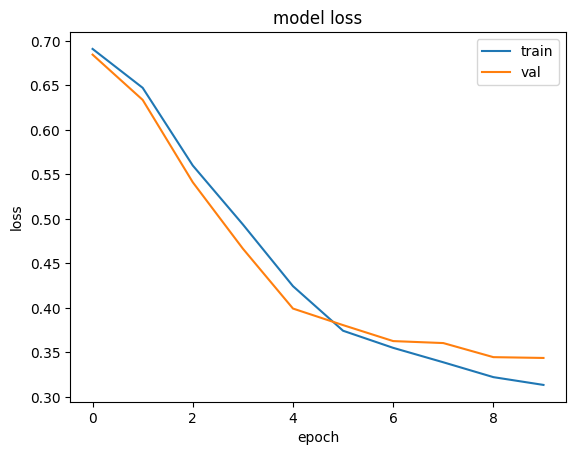

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

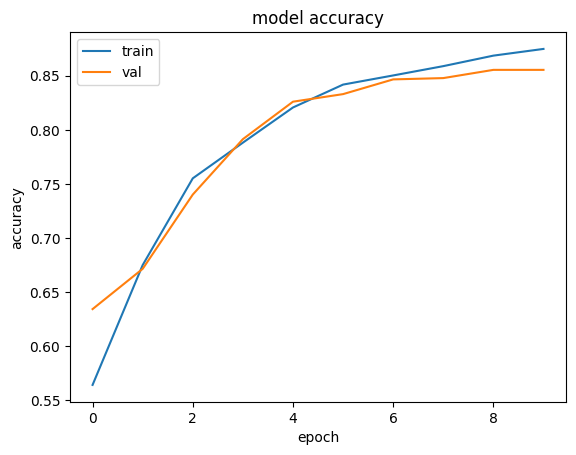

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 12s 15ms/step - loss: 0.3374 - accuracy: 0.8560
Test Loss: 0.33741241693496704
Test Accuracy: 0.8559600114822388


# Comparisons between implementations

Overall, the results are in the attached photo. Despite its high parameter count, the Glove implementation has the best balance between accuracy and training time. 

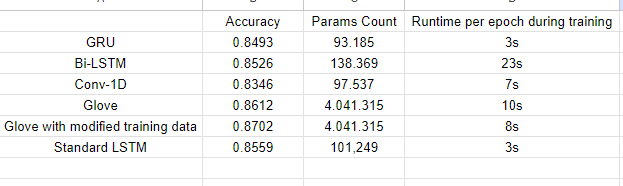

**Accuracy:**

The most accurate implementation is Glove, however, it has the most parameters out of all implementations. Both the higher accuracy and the number of parameters of the Glove implementation can be attributed to the use of pretrained Glove word vectors.

In order from most accurate to least, the order are: Glove LSTM > Standard LSTM > Bi-LSTM > GRU > Conv1D


**Running Time:**

The implementation with Bi-LSTM has the longest training time. I believe that this is because Bi-LSTM has to find relationship between words in two directions instead of 1. 

In order of faster running time to the slowest, the order are: GRU/Standard LSTM > Conv1D > Glove > Bi-LSTM

**Parameter Number:**

The implementation with the most parameters is Glove due to the use of pretrained Glove word vectors. 

The implementation with the least parameters is GRU. This is likely because GRU's architecture has fewer componenets than LSTM so its parameter count is lower than LSTM.

**Glove LSTM vs Standard LSTM**

Between Glove LSTM and Standard LSTM, Glove LSTM is more accurate; however, it is around three times slower than Standard LSTM. If accuracy is the priority, we should go with Glove LSTM, if running time is the priority, we should go with Standard LSTM 